In [1]:
import numpy as np

import torch
from torch import nn
from torch import optim

import tqdm

import tkinter

from IPython.display import clear_output

In [2]:
import sys
sys.path.append('..')

from samplers_new import mala, i_sir, ex2_mcmc

In [3]:
from cifar10_experiments.models import Generator, Discriminator

In [4]:
device = 'cpu'
lat_size=100

In [5]:
gen_cifar10 = Generator(lat_size)
gen_cifar10.to(device)

discr_cifar10 = Discriminator()
discr_cifar10.to(device)

prior_cifar10 = torch.distributions.MultivariateNormal(torch.zeros(lat_size).to(device), torch.eye(lat_size).to(device))

In [6]:
gen_cifar10.load_state_dict(torch.load('./weights/generator.pkl', map_location='cpu'))
discr_cifar10.load_state_dict(torch.load('./weights/discriminator.pkl', map_location='cpu'))
gen_cifar10.eval()
discr_cifar10.eval();

In [7]:
def get_energy_wgan(z):
    return (-discr_cifar10(gen_cifar10(z)).reshape(z.shape[0]) - prior_cifar10.log_prob(z))

def log_target_dens(z, detach=True, batch_size=128):
    """
    returns the value of a target density - mixture of the 3 gaussians 
    """
    res = []
    for i in range(z.shape[0] // batch_size + (1 if z.shape[0] % batch_size else 0)):
        cur_res = -get_energy_wgan(z[batch_size * i: batch_size * (i+1)])
        
        if detach:
            cur_res = cur_res.detach()
        
        res.append(cur_res)
    
    return torch.cat(res)

In [8]:
log_target_dens(torch.randn(2, lat_size))

tensor([-1590.2795, -1659.4919])

### Put parameters of the target density

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
seed = 42
torch.manual_seed(42)

N_samples=10

x0 = torch.randn(N_samples, lat_size).to(device)

100%|█████████████████████████████████████████████| 9/9 [01:17<00:00,  8.66s/it]


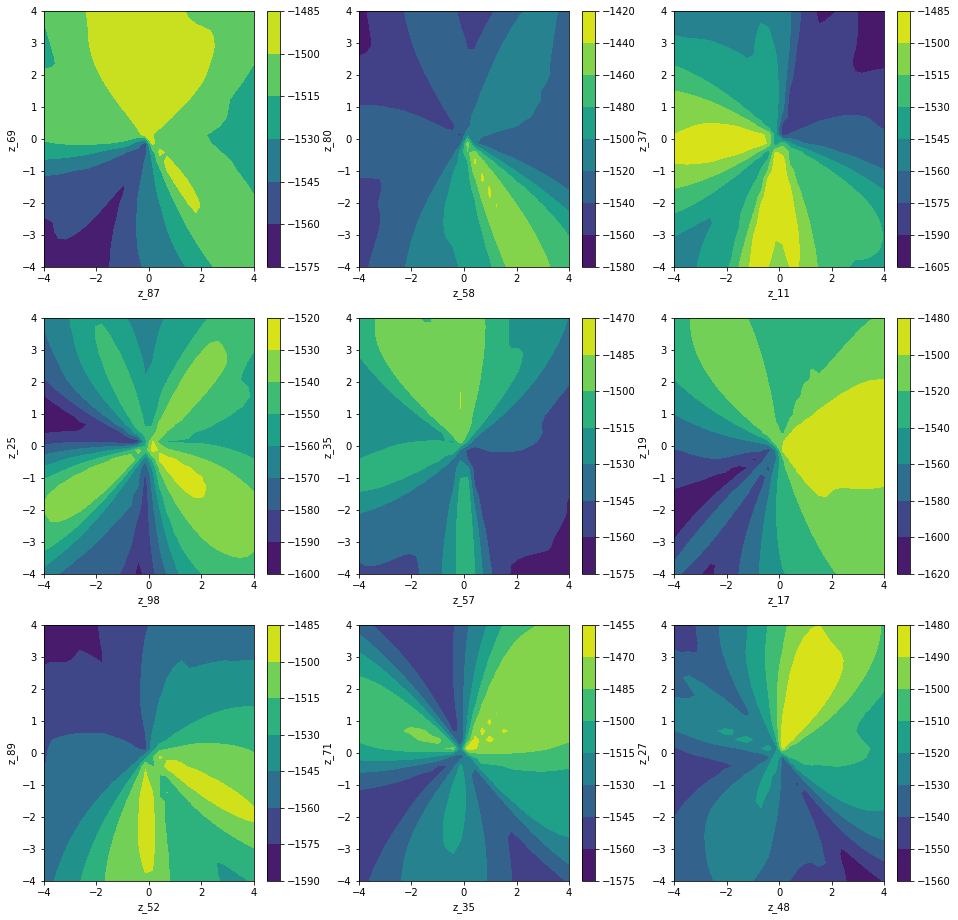

In [10]:
a = 2

plt.figure(figsize=(16, 16))

idxs = []
dens = []

for j in tqdm.tqdm(range(9)):
    idxs_perm = np.random.permutation(np.arange(lat_size))
    
    i1 = idxs_perm[0]
    i2 = idxs_perm[1]
    
    c1 = torch.zeros(lat_size).to(device)
    c1[i1] = 1

    c2 = torch.zeros(lat_size).to(device)
    c2[i2] = 1

    idxs.append((i1, i2))
    
    N_pts = 30
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)
    points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
    points[:, :, 0] = X
    points[:, :, 1] = Y

    points = points.reshape(-1, 2)
    points = torch.FloatTensor(points).to(device)
    
    z = points @ torch.stack((c1, c2))
    
    dens_vals = log_target_dens(z).detach().cpu().numpy()
    
    dens_vals = dens_vals.reshape(N_pts, N_pts)
    
    dens.append(dens_vals)

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

# I-SIR

In [19]:
from torch.distributions import MultivariateNormal

sigma_isir = 1.0
isir_proposal = MultivariateNormal(
    torch.zeros(lat_size).to(device), 
    (sigma_isir ** 2) * torch.eye(lat_size).to(device))

N_particles = 10
N_steps = 100

Samples_isir = i_sir(log_target_dens=log_target_dens, x0=x0, N_steps=N_steps, N_part=N_particles, isir_proposal=isir_proposal)

energies_isir = -log_target_dens(Samples_isir.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 28.30it/s]


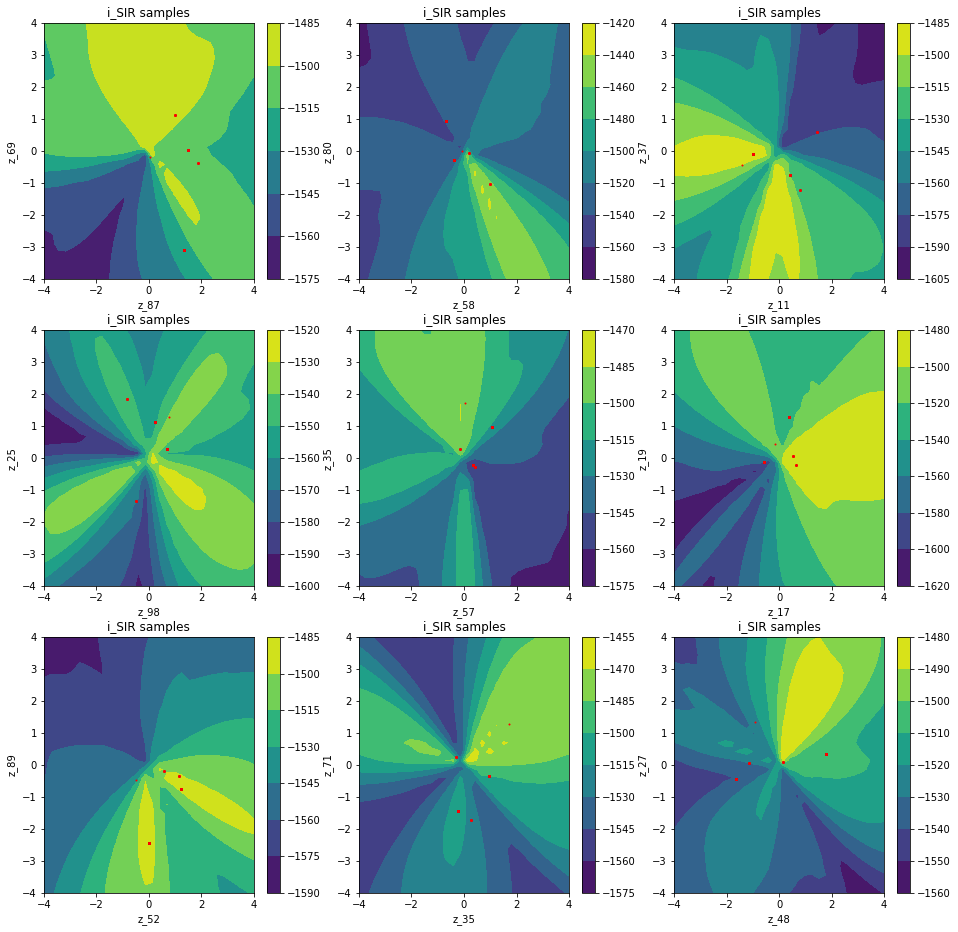

In [33]:
a = 2

plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 30
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(Samples_isir[0, :, i1].cpu().numpy(), Samples_isir[0, :, i2].cpu().numpy(), s=1, c='r')
    plt.title('i_SIR samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

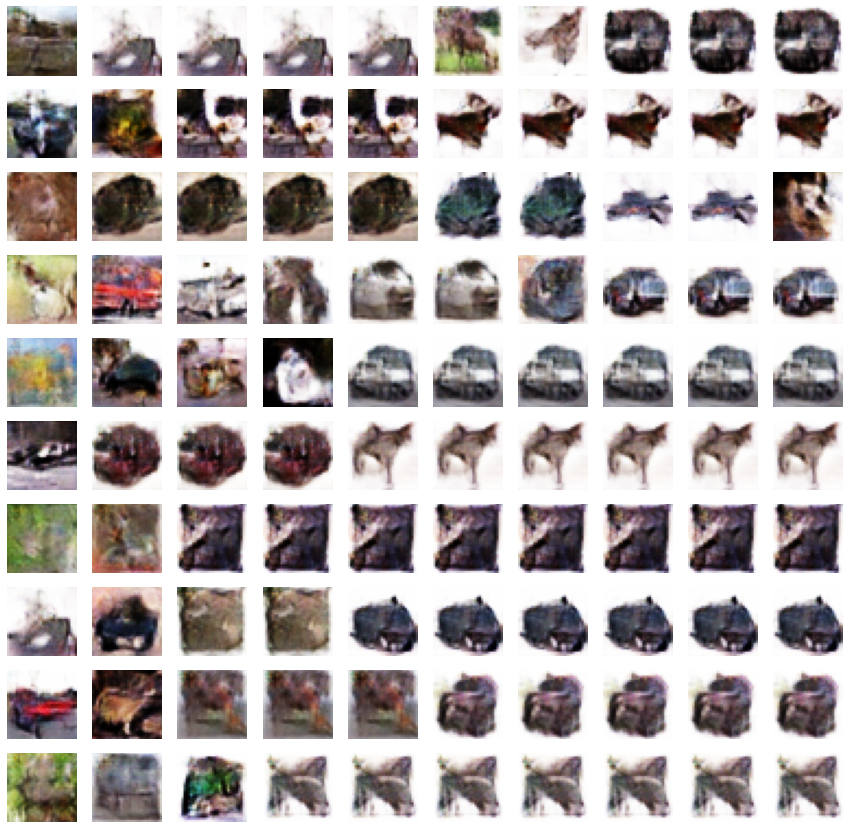

In [34]:
plt.figure(figsize=(15, 15))

for traj_i in range(10):
    for step_i in range(10):
        plt.subplot(10, 10, 10 * traj_i + step_i + 1)
        img = gen_cifar10(torch.FloatTensor(Samples_isir[traj_i, step_i * 10:step_i * 10 + 1]))[0].detach().cpu().numpy()
        img = (img + 1) / 2
        
        plt.axis('off')
        plt.imshow(img.transpose((1, 2, 0)))

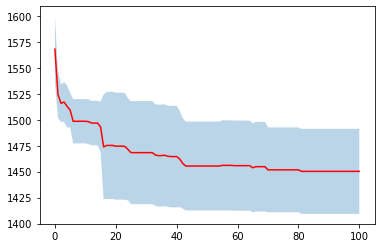

In [37]:
means = energies_isir.mean(dim=0)
stds = energies_isir.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='r')
plt.fill_between(np.arange(N_steps + 1), means - stds, means + stds, alpha=0.3)

# MALA

In [38]:
N_steps = 100

gamma = 5e-3
mala_iters = 3

n_accepts = 0

Samples_mala = mala(log_target_dens=log_target_dens, x0=x0, N_steps=N_steps, gamma=gamma, mala_iters=mala_iters, n_accepts=n_accepts)

energies_mala = -log_target_dens(Samples_mala.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|█████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 29.43it/s]


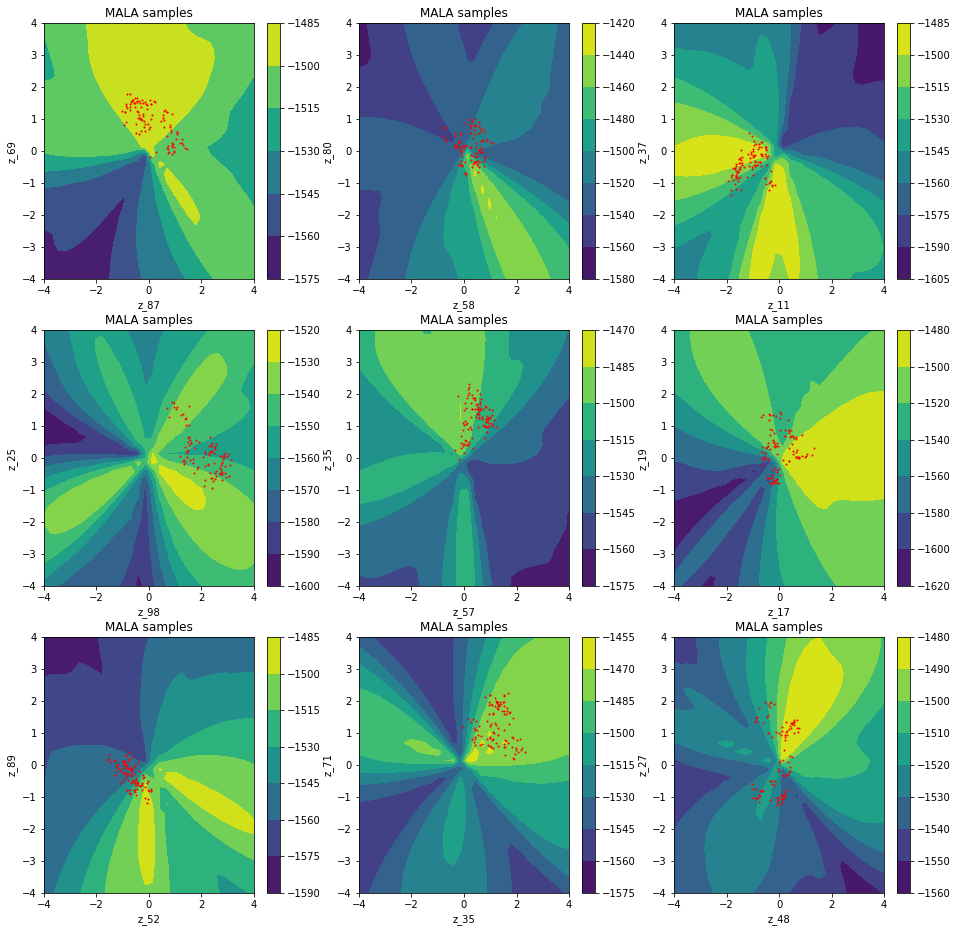

In [39]:
a = 2

plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 30
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(Samples_mala[0, :, i1].cpu().numpy(), Samples_mala[0, :, i2].cpu().numpy(), s=1, c='r')
    plt.title('MALA samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

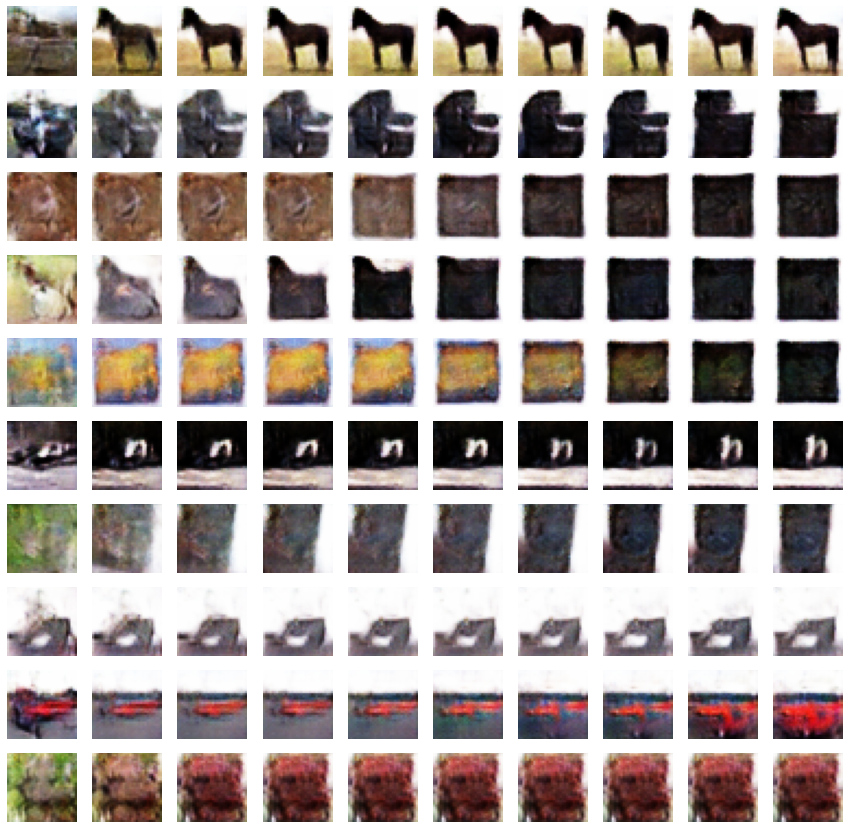

In [40]:
plt.figure(figsize=(15, 15))

for traj_i in range(10):
    for step_i in range(10):
        plt.subplot(10, 10, 10 * traj_i + step_i + 1)
        img = gen_cifar10(torch.FloatTensor(Samples_mala[traj_i, step_i * 10:step_i * 10 + 1]))[0].detach().cpu().numpy()
        img = (img + 1) / 2
        
        plt.axis('off')
        plt.imshow(img.transpose((1, 2, 0)))

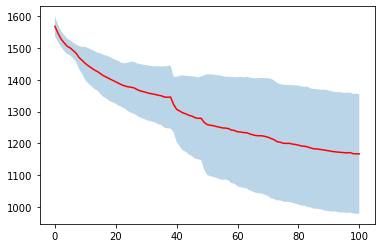

In [41]:
means = energies_mala.mean(dim=0)
stds = energies_mala.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='r')
plt.fill_between(np.arange(N_steps + 1), means - stds, means + stds, alpha=0.3)

# Ex2MCMC

In [42]:
N_steps = 100

sigma_isir = 1.0
isir_proposal = MultivariateNormal(
    torch.zeros(lat_size).to(device), 
    (sigma_isir ** 2) * torch.eye(lat_size).to(device))

N_particles = 10

gamma = 5e-3
mala_iters = 3

n_accepts = 0

Samples_ex2 = ex2_mcmc(log_target_dens=log_target_dens, x0=x0, N_steps=N_steps, 
                       N_part=N_particles, isir_proposal=isir_proposal ,
                       gamma=gamma, mala_iters=mala_iters, n_accepts=n_accepts)

energies_ex2 = -log_target_dens(Samples_ex2.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|█████████████████████████████████████████| 100/100 [04:07<00:00,  2.47s/it]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 63.54it/s]


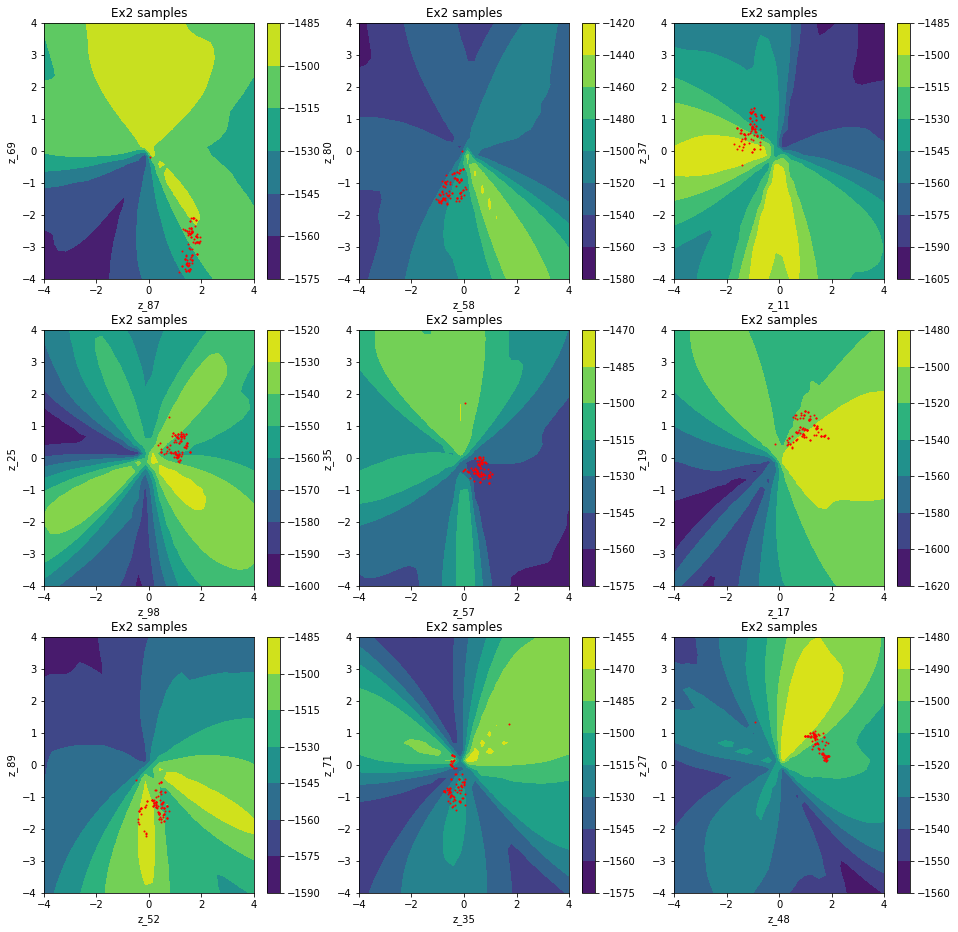

In [47]:
a = 2

plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 30
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(Samples_ex2[0, :, i1].cpu().numpy(), Samples_ex2[0, :, i2].cpu().numpy(), s=1, c='r')
    plt.title('Ex2 samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

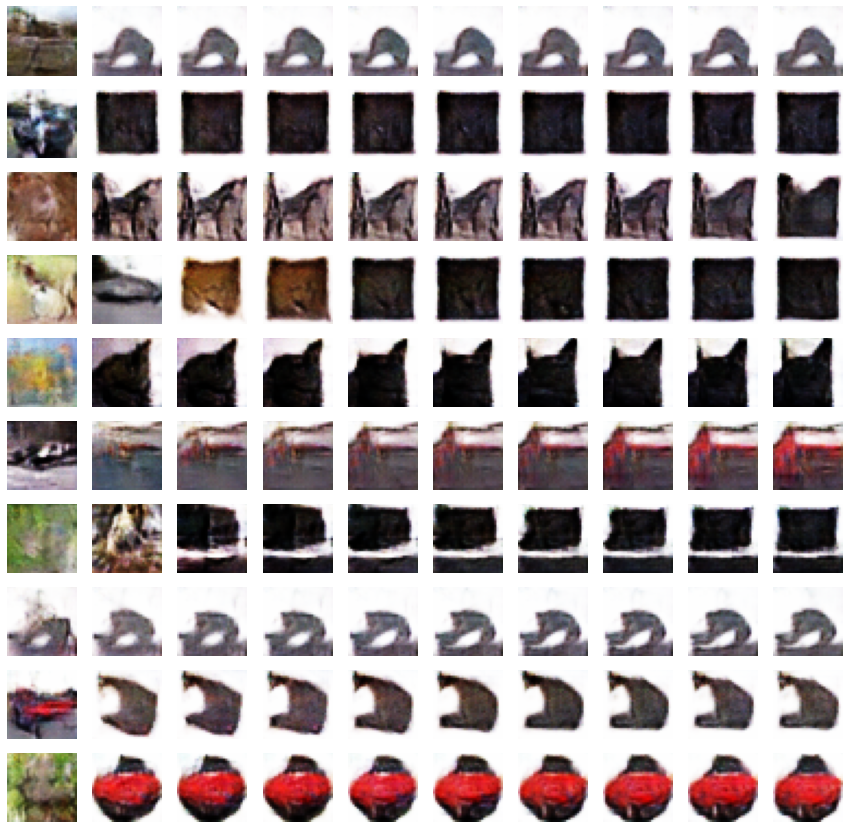

In [48]:
plt.figure(figsize=(15, 15))

for traj_i in range(10):
    for step_i in range(10):
        plt.subplot(10, 10, 10 * traj_i + step_i + 1)
        img = gen_cifar10(torch.FloatTensor(Samples_ex2[traj_i, step_i * 10:step_i * 10 + 1]))[0].detach().cpu().numpy()
        img = (img + 1) / 2
        
        plt.axis('off')
        plt.imshow(img.transpose((1, 2, 0)))

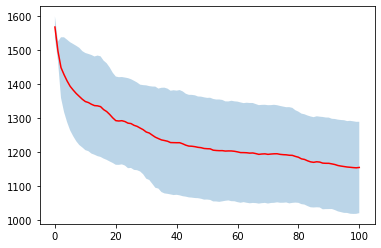

In [49]:
means = energies_ex2.mean(dim=0)
stds = energies_ex2.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='r')
plt.fill_between(np.arange(N_steps + 1), means - stds, means + stds, alpha=0.3)

### Plot all 3 pictures together

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 55.92it/s]


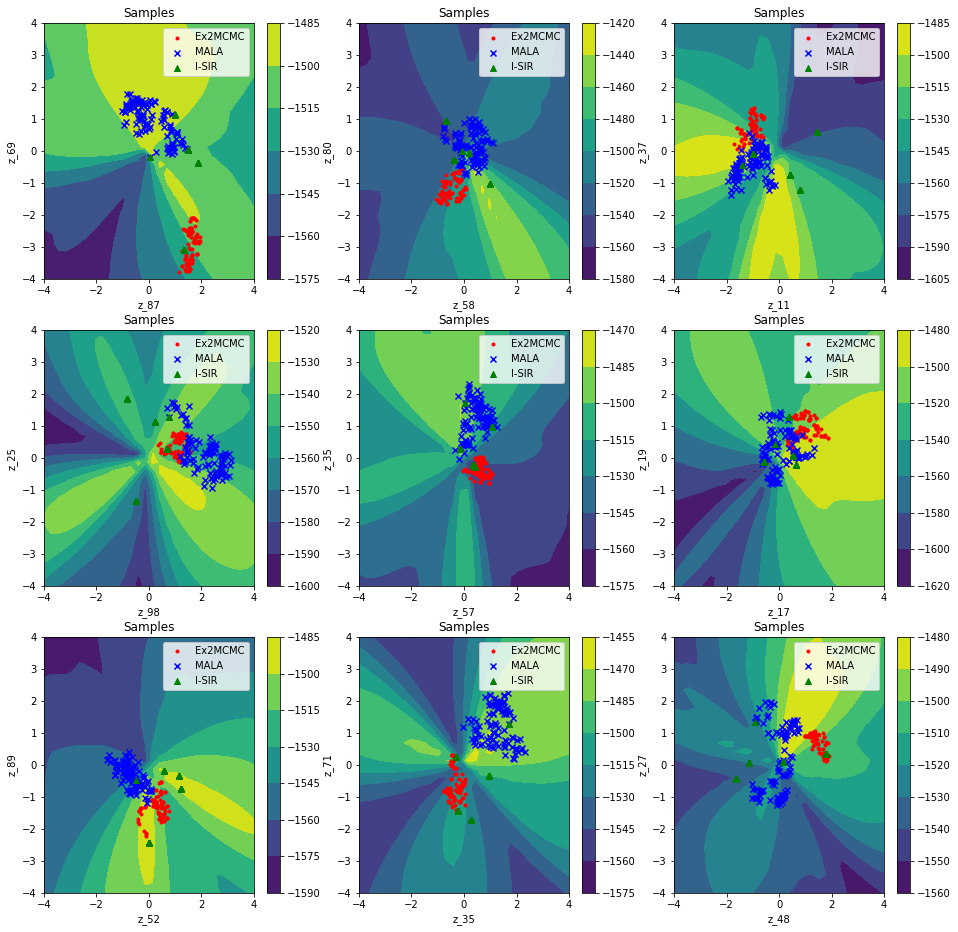

In [50]:
a = 2

plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 30
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(Samples_ex2[0, :, i1], Samples_ex2[0, :, i2],  c='r', marker='.', label='Ex2MCMC') 
    plt.scatter(Samples_mala[0, :, i1], Samples_mala[0, :, i2], c='b', marker='x', label='MALA')
    plt.scatter(Samples_isir[0, :, i1], Samples_isir[0, :, i2], c='g', marker='^', label='I-SIR')
    
    plt.legend()
    
    plt.title('Samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

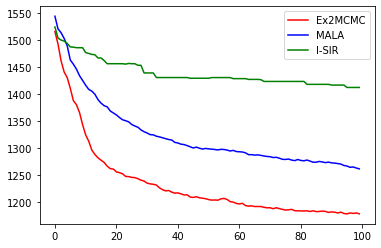

In [25]:
means = energies_ex2.mean(dim=0)
stds = energies_ex2.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='r', label='Ex2MCMC')
#plt.fill_between(np.arange(N_steps), means - stds, means + stds, color='r', alpha=0.2)


means = energies_mala.mean(dim=0)
stds = energies_mala.std(dim=0)

plt.plot(np.arange(N_steps), means, c='b', label='MALA')
#plt.fill_between(np.arange(N_steps), means - stds, means + stds, color='b', alpha=0.2)

means = np.array([e.mean() for e in energies_isir])
stds = np.array([e.std() for e in energies_isir])

plt.plot(np.arange(N_steps), means, c='g', label='I-SIR')
#plt.fill_between(np.arange(N_steps), means - stds, means + stds, color='g', alpha=0.2)



plt.legend()